In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.float = float    
np.int = int   
np.object = object  
np.bool = bool   

In [2]:
file_path = "WSTS-Historical-Billings-Report-May2025.xlsx"
monthly_data = pd.read_excel(file_path, sheet_name="Monthly Data")

# Drop top non-data rows and reset index.
cleaned_data = monthly_data.drop(index=[0, 1, 2, 3]).reset_index(drop=True)

# Use actual header row (row 2 in original Excel) to set column names.
header_row = monthly_data.iloc[2]
cleaned_data.columns = header_row
cleaned_data = cleaned_data.rename(columns={cleaned_data.columns[0]: "Region"})

# Filter for Americas and Worldwide.
americas_data = cleaned_data[cleaned_data["Region"] == "Americas"][["Region", "Total Year"]].copy()
worldwide_data = cleaned_data[cleaned_data["Region"] == "Worldwide"][["Region", "Total Year"]].copy()

# Assign year range based on known starting year (1986).
americas_data["Year"] = range(1986, 1986 + len(americas_data))
worldwide_data["Year"] = range(1986, 1986 + len(worldwide_data))

# Convert revenue to numeric.
americas_data["Total Year"] = pd.to_numeric(americas_data["Total Year"], errors='coerce')
worldwide_data["Total Year"] = pd.to_numeric(worldwide_data["Total Year"], errors='coerce')

In [3]:
# Merge both datasets on Year.
merged_data = pd.merge(americas_data, worldwide_data, on="Year", suffixes=("_Americas", "_Worldwide"))

# Calculate percentage share.
merged_data["Americas_Share_Percent"] = (
    merged_data["Total Year_Americas"] / merged_data["Total Year_Worldwide"]
) * 100

# View the final DataFrame.
print(merged_data[["Year", "Total Year_Americas", "Total Year_Worldwide", "Americas_Share_Percent"]])

2   Year  Total Year_Americas  Total Year_Worldwide  Americas_Share_Percent
0   1986              8508557              26355359               32.283973
1   1987             10259204              32530452               31.537232
2   1988             13418040              45004809               29.814680
3   1989             14829035              48762926               30.410470
4   1990             14445437              50518932               28.594106
5   1991             15376273              54607454               28.157828
6   1992             18410756              59864958               30.753811
7   1993             24744008              77309681               32.006351
8   1994             33561586             101878593               32.942726
9   1995             46998462             144403681               32.546582
10  1996             42679016             131966432               32.340812
11  1997             45850894             137203120               33.418259
12  1998    

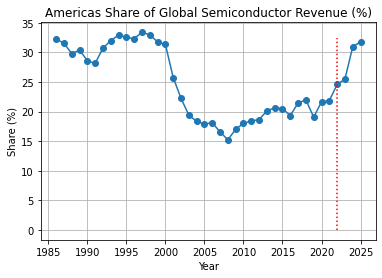

In [4]:
plt.plot(merged_data["Year"], merged_data["Americas_Share_Percent"], marker='o')
plt.title("Americas Share of Global Semiconductor Revenue (%)")
plt.vlines(2022,0,32.5,linestyles="dotted",color='red')
plt.xlabel("Year")
plt.ylabel("Share (%)")
plt.grid(True)
plt.show()

In [5]:
share_2025 = merged_data[merged_data["Year"] == 2025]["Americas_Share_Percent"].values[0]
print(f"Americas Share in 2025: {share_2025:.2f}%")

Americas Share in 2025: 31.82%


### Bootstrapping.

In [6]:
# Calculate YoY percentage changes in Americas share
merged_data["YoY_Change"] = merged_data["Americas_Share_Percent"].pct_change()

# Drop NaN from the first row
yoy_changes = merged_data["YoY_Change"].dropna().values

# Last known Americas share percentage (2024)
latest_share = merged_data["Americas_Share_Percent"].iloc[-1]

n_simulations = 10000
forecasted_shares = []

# Perform bootstrap sampling
np.random.seed(42)
for _ in range(n_simulations):
    sampled_changes = np.random.choice(yoy_changes, size=1, replace=True)
    forecasted_share = latest_share * (1 + sampled_changes[0])
    forecasted_shares.append(forecasted_share)

forecasted_shares = np.array(forecasted_shares)
prob_exceeds_35 = np.mean(forecasted_shares > 35) * 100
prob_exceeds_35

12.46